Paper: [Evidential Deep Learning to Quantify Classification
Uncertainty](https://arxiv.org/pdf/1806.01768)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [66]:
train_val_data = MNIST(
    "./data",
    download=True,
    transform=torchvision.transforms.Compose(
        [
            # torchvision.transforms.Pad(padding=2),
            torchvision.transforms.ToTensor(),
        ]
    ),
)
test_dataset = MNIST(
    "./data",
    download=True,
    train=False,
    transform=torchvision.transforms.Compose(
        [
            # torchvision.transforms.Pad(padding=2),
            torchvision.transforms.ToTensor(),
        ]
    ),
)
val_size = 10000
train_size = len(train_val_data) - val_size
train_dataset, val_dataset = random_split(train_val_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

onebatch_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=False,
    sampler=torch.utils.data.RandomSampler(train_dataset, num_samples=64),
)


print(len(train_dataset), len(val_dataset), len(test_dataset))

50000 10000 10000


# baseline


In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(64 * 5 * 5, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.classifier(x)
        return x


model = Net()
sample = next(iter(train_loader))[0]
print(sample.shape)
model(sample).shape

torch.Size([64, 1, 28, 28])


torch.Size([64, 10])

In [46]:
model = Net()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
metrics = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = 100.0 * correct / total

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = loss_fn(output, target)

            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100.0 * val_correct / val_total

    # Store metrics
    metrics["train_loss"].append(epoch_train_loss)
    metrics["train_acc"].append(epoch_train_acc)
    metrics["val_loss"].append(epoch_val_loss)
    metrics["val_acc"].append(epoch_val_acc)

    print(f"Epoch: {epoch}")
    print(
        f"Training - Loss: {epoch_train_loss:.3f}, " f"Accuracy: {epoch_train_acc:.2f}%"
    )
    print(
        f"Validation - Loss: {epoch_val_loss:.3f}, " f"Accuracy: {epoch_val_acc:.2f}%"
    )
    print("--------------------")


Epoch: 0
Training - Loss: 0.213, Accuracy: 93.31%
Validation - Loss: 0.085, Accuracy: 97.52%
--------------------
Epoch: 1
Training - Loss: 0.060, Accuracy: 98.13%
Validation - Loss: 0.052, Accuracy: 98.51%
--------------------
Epoch: 2
Training - Loss: 0.041, Accuracy: 98.69%
Validation - Loss: 0.052, Accuracy: 98.44%
--------------------
Epoch: 3
Training - Loss: 0.031, Accuracy: 99.02%
Validation - Loss: 0.045, Accuracy: 98.69%
--------------------
Epoch: 4
Training - Loss: 0.024, Accuracy: 99.25%
Validation - Loss: 0.046, Accuracy: 98.68%
--------------------
Epoch: 5
Training - Loss: 0.018, Accuracy: 99.41%
Validation - Loss: 0.050, Accuracy: 98.75%
--------------------
Epoch: 6
Training - Loss: 0.015, Accuracy: 99.50%
Validation - Loss: 0.038, Accuracy: 99.05%
--------------------
Epoch: 7
Training - Loss: 0.014, Accuracy: 99.54%
Validation - Loss: 0.043, Accuracy: 98.94%
--------------------
Epoch: 8
Training - Loss: 0.009, Accuracy: 99.69%
Validation - Loss: 0.049, Accuracy: 98

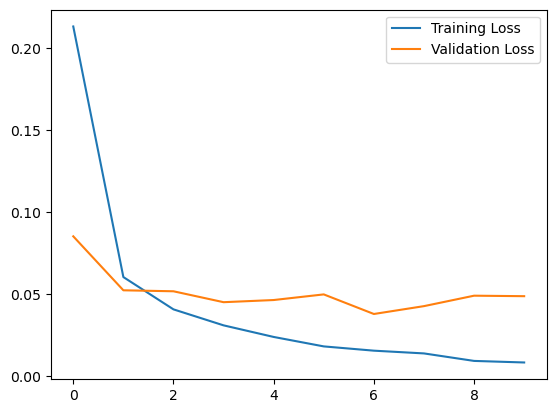

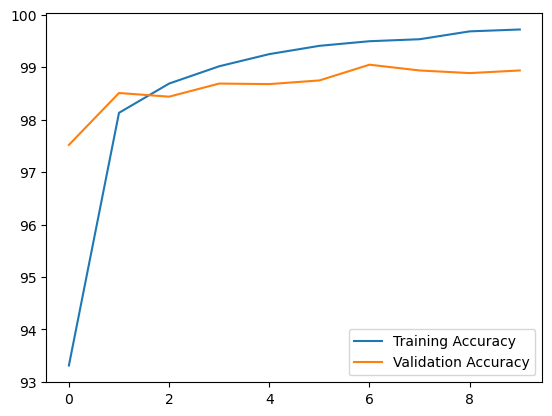

In [47]:
plt.plot(metrics["train_loss"], label="Training Loss")
plt.plot(metrics["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

plt.plot(metrics["train_acc"], label="Training Accuracy")
plt.plot(metrics["val_acc"], label="Validation Accuracy")
plt.legend()
plt.show()

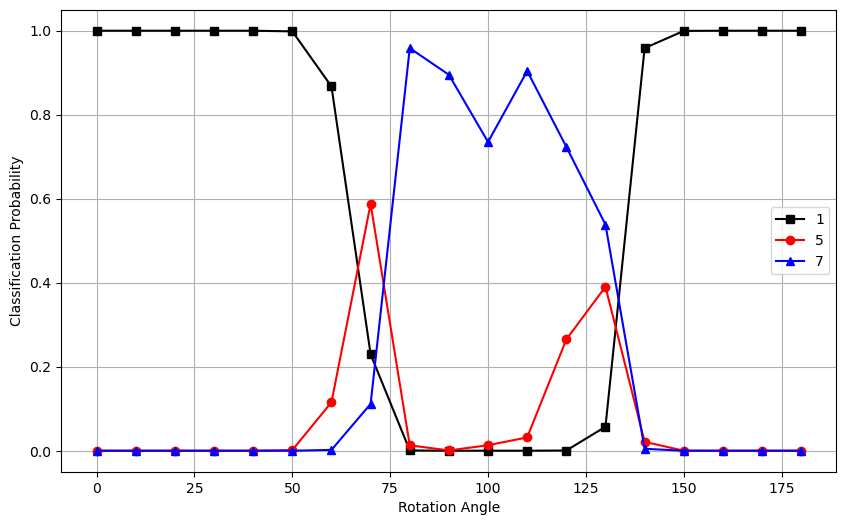

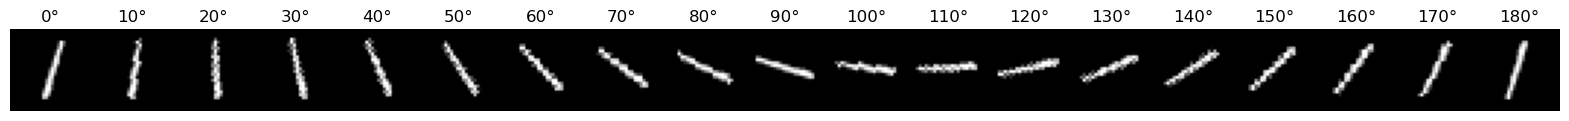

In [60]:
# Get a single example of digit 1
digit_1_idx = (test_dataset.targets == 1).nonzero()[0]
example_1 = test_dataset[digit_1_idx[0]][0]
angles = np.arange(0.0, 181.0, 10.0)
probabilities = []

model.eval()
rotated_images = []
with torch.no_grad():
    for angle in angles:
        rotated_img = transforms.functional.rotate(example_1, angle)
        rotated_images.append(rotated_img.squeeze().numpy())
        input_tensor = rotated_img.unsqueeze(0)
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        probabilities.append(probs[0].numpy())

# Convert to numpy array for easier plotting
probabilities = np.array(probabilities)

# Plot the probabilities for digits 1, 2, and 5
plt.figure(figsize=(10, 6))
plt.plot(angles, probabilities[:, 1], "k-s", label="1")
plt.plot(angles, probabilities[:, 5], "r-o", label="5")
plt.plot(angles, probabilities[:, 7], "b-^", label="7")
# Plot probabilities for all digits 0-9 - i chose the high ones to show
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
#           '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H']

# for digit in range(10):
#     plt.plot(angles, probabilities[:, digit],
#              color=colors[digit],
#              marker=markers[digit],
#              label=str(digit))

plt.xlabel("Rotation Angle")
plt.ylabel("Classification Probability")
plt.legend()
plt.grid(True)
plt.show()

# Plot rotated images in one row
num_images = len(rotated_images)
fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
plt.subplots_adjust(wspace=0, hspace=0)
for i, img in enumerate(rotated_images):
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"{int(angles[i])}°")
plt.show()


# Evidential classification


In [109]:
# https://muratsensoy.github.io/uncertainty.html
# https://github.com/dougbrion/pytorch-classification-uncertainty/blob/master/losses.py
def edl_mse_loss(output, y, epoch_num, num_classes, annealing_step=3):
    """
    Gripes:
    * paper says epoch_num, but their implementation uses a global step count, not epoch, making it a batch level count
    * kl_alpha = (alpha - 1) * (1 - y) + 1 is NOT what is mentioned in the paper as alpha(with tilde)
        * it's actually y + (1 - y) * alpha that is mentioned.
        * update: those two expressions are the same. I'll use the form from the paper.
    """
    evidence = F.softplus(output)
    alpha = evidence + 1  # direchlet prior
    # the evidential loss. Still needs regularisation as this alone, just fits the data.
    # During an incorrect prediction, there is no incentive to be unceratain
    S = torch.sum(alpha, dim=1, keepdim=True)
    loglikelihood_err = torch.sum((y - (alpha / S)) ** 2, dim=1, keepdim=True)
    loglikelihood_var = torch.sum(
        alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True
    )
    loglikelihood = loglikelihood_err + loglikelihood_var

    # KL[D(p_i|α̃_i) || D(p_i|1)]
    # The loss penalizes divergence from uniform direchlet distribution
    # unless there's strong evidence to support a prediction.
    # encourages complete uncertainty (uniform direchlet) when appropriate
    kl_alpha = y + (1 - y) * alpha
    ones = torch.ones([1, num_classes], dtype=torch.float32)
    sum_alpha = torch.sum(kl_alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)  # log(Γ(∑α̃_ik))
        - torch.lgamma(kl_alpha).sum(
            dim=1, keepdim=True
        )  # -log(∏Γ(α̃_ik)), sum of logs = log(mult(inner terms))
        # + torch.lgamma(ones).sum(dim=1, keepdim=True)  # not needed, is all zero
        - torch.lgamma(ones.sum(dim=1, keepdim=True))  # -log(Γ(K))
    )
    second_term = (
        (kl_alpha - ones)
        .mul(torch.digamma(kl_alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term

    # the regularisation coefficient, called "annealing" coeff
    # annealing coefficient that increases over training epochs,∈(min(1.0, t/10))
    # emperical
    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    loss = loglikelihood + annealing_coef * kl
    return torch.mean(loss)


# takes one hot encoded targets!
sample_x, sample_y = next(iter(train_loader))
y_one_hot = F.one_hot(sample_y, num_classes=len(test_dataset.targets.unique())).float()
edl_mse_loss(Net()(sample_x), y_one_hot, 1, 10)

tensor(1.1872, grad_fn=<MeanBackward0>)

In [110]:
sample_x.shape

torch.Size([64, 1, 28, 28])

In [111]:
model_evid = Net()
optimizer = torch.optim.Adam(model_evid.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

epochs = 10
annealing_step = 10
metrics = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(epochs):
    model_evid.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model_evid(data)
        # One-hot encode the target
        target_one_hot = F.one_hot(
            target, num_classes=len(test_dataset.targets.unique())
        ).float()
        loss = edl_mse_loss(
            output,
            target_one_hot,
            epoch,
            len(test_dataset.targets.unique()),
            annealing_step=annealing_step,
        )
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    # scheduler.step()

    epoch_train_loss = train_loss / len(train_loader)
    epoch_train_acc = 100.0 * correct / total

    # Validation
    model_evid.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data, target in val_loader:
            # One-hot encode the target
            target_one_hot = F.one_hot(
                target, num_classes=len(test_dataset.targets.unique())
            ).float()
            output = model_evid(data)
            loss = edl_mse_loss(
                output,
                target_one_hot,
                epoch,
                len(test_dataset.targets.unique()),
                annealing_step=annealing_step,
            )

            val_loss += loss.item()
            _, predicted = output.max(1)
            val_total += target.size(0)
            val_correct += predicted.eq(target).sum().item()

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = 100.0 * val_correct / val_total

    # Store metrics
    metrics["train_loss"].append(epoch_train_loss)
    metrics["train_acc"].append(epoch_train_acc)
    metrics["val_loss"].append(epoch_val_loss)
    metrics["val_acc"].append(epoch_val_acc)

    print(f"Epoch: {epoch}")
    print(
        f"Training - Loss: {epoch_train_loss:.3f}, " f"Accuracy: {epoch_train_acc:.2f}%"
    )
    print(
        f"Validation - Loss: {epoch_val_loss:.3f}, " f"Accuracy: {epoch_val_acc:.2f}%"
    )
    print("--------------------")

Epoch: 0
Training - Loss: 0.216, Accuracy: 87.67%
Validation - Loss: 0.090, Accuracy: 95.51%
--------------------
Epoch: 1
Training - Loss: 0.120, Accuracy: 96.35%
Validation - Loss: 0.093, Accuracy: 97.22%
--------------------
Epoch: 2
Training - Loss: 0.104, Accuracy: 97.36%
Validation - Loss: 0.100, Accuracy: 97.45%
--------------------
Epoch: 3
Training - Loss: 0.100, Accuracy: 97.66%
Validation - Loss: 0.119, Accuracy: 97.29%
--------------------
Epoch: 4
Training - Loss: 0.096, Accuracy: 97.92%
Validation - Loss: 0.103, Accuracy: 97.85%
--------------------
Epoch: 5
Training - Loss: 0.090, Accuracy: 98.08%
Validation - Loss: 0.108, Accuracy: 97.89%
--------------------
Epoch: 6
Training - Loss: 0.084, Accuracy: 98.32%
Validation - Loss: 0.094, Accuracy: 98.19%
--------------------
Epoch: 7
Training - Loss: 0.087, Accuracy: 98.42%
Validation - Loss: 0.114, Accuracy: 98.04%
--------------------
Epoch: 8
Training - Loss: 0.084, Accuracy: 98.36%
Validation - Loss: 0.108, Accuracy: 98

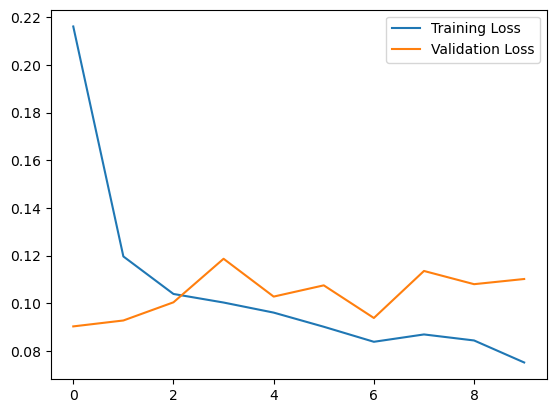

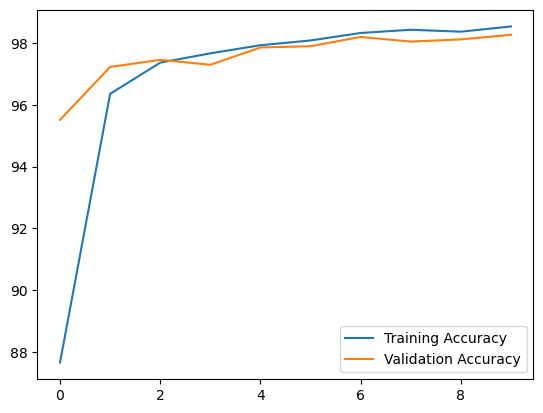

In [113]:
plt.plot(metrics["train_loss"], label="Training Loss")
plt.plot(metrics["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

plt.plot(metrics["train_acc"], label="Training Accuracy")
plt.plot(metrics["val_acc"], label="Validation Accuracy")
plt.legend()
plt.show()

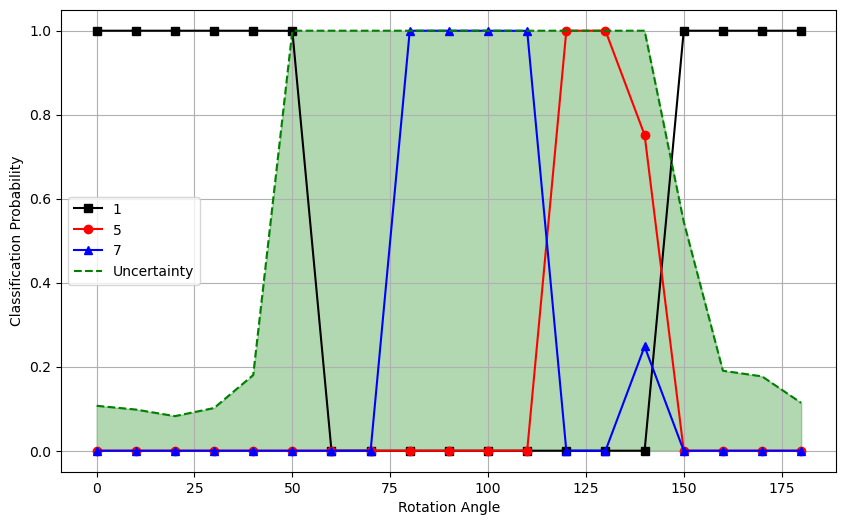

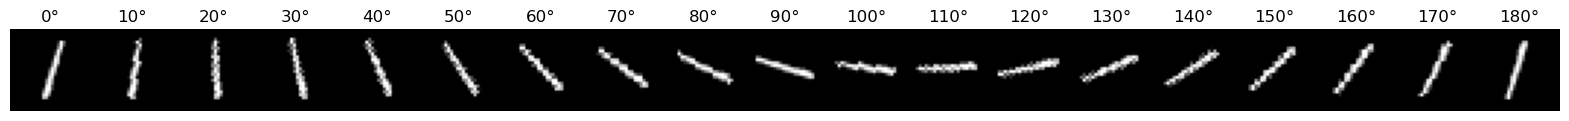

In [120]:
# Get a single example of digit 1
digit_1_idx = (test_dataset.targets == 1).nonzero()[0]
example_1 = test_dataset[digit_1_idx[0]][0]
angles = np.arange(0.0, 181.0, 10.0)
probabilities = []
uncertainties = []

model_evid.eval()
rotated_images = []
with torch.no_grad():
    for angle in angles:
        rotated_img = transforms.functional.rotate(example_1, angle)
        rotated_images.append(rotated_img.squeeze().numpy())
        input_tensor = rotated_img.unsqueeze(0)
        output = model_evid(input_tensor)
        num_classes = 10
        uncertainty = num_classes / torch.sum(F.softplus(output) + 1, dim=1)
        probs = F.softmax(output, dim=1)
        probabilities.append(probs[0].numpy())
        uncertainties.append(uncertainty[0].numpy())

# Convert to numpy array for easier plotting
probabilities = np.array(probabilities)
uncertainties = np.array(uncertainties)

# Plot the probabilities for digits 1, 2, and 5
plt.figure(figsize=(10, 6))
plt.plot(angles, probabilities[:, 1], "k-s", label="1")
plt.plot(angles, probabilities[:, 5], "r-o", label="5")
plt.plot(angles, probabilities[:, 7], "b-^", label="7")
plt.plot(angles, uncertainties, "g--", label="Uncertainty")
plt.fill_between(angles, uncertainties, alpha=0.3, color="g")


plt.xlabel("Rotation Angle")
plt.ylabel("Classification Probability")
plt.legend()
plt.grid(True)
plt.show()

# Plot rotated images in one row
num_images = len(rotated_images)
fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
plt.subplots_adjust(wspace=0, hspace=0)
for i, img in enumerate(rotated_images):
    axes[i].imshow(img, cmap="gray")
    axes[i].axis("off")
    axes[i].set_title(f"{int(angles[i])}°")
plt.show()